Licensed under the MIT License.

Copyright (c) 2021-2031. All rights reserved.

# Try Different Semi-Supervised Solutions and Compare

* All mask 90% labels

* References
  * Label Propagation: https://towardsdatascience.com/semi-supervised-learning-how-to-assign-labels-with-label-propagation-algorithm-9f1683f4d0eb
    * Sklearn function: https://scikit-learn.org/stable/modules/generated/sklearn.semi_supervised.LabelPropagation.html
  * Label Spreading: https://towardsdatascience.com/how-to-benefit-from-the-semi-supervised-learning-with-label-spreading-algorithm-2f373ae5de96
    * Sklearn function: https://scikit-learn.org/stable/modules/generated/sklearn.semi_supervised.LabelSpreading.html#sklearn.semi_supervised.LabelSpreading
  * Self Training: https://towardsdatascience.com/self-training-classifier-how-to-make-any-algorithm-behave-like-a-semi-supervised-one-2958e7b54ab7
    * Sklearn function: https://scikit-learn.org/stable/modules/generated/sklearn.semi_supervised.SelfTrainingClassifier.html#sklearn.semi_supervised.SelfTrainingClassifier

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from lightgbm import LGBMClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.semi_supervised import LabelPropagation, LabelSpreading, SelfTrainingClassifier
from category_encoders import TargetEncoder
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')

In [2]:
def mask_labels(df, label_col, masked_label, mask_rate=0.95):
    df['keep_label'] = True 
    df.loc[df.sample(frac=mask_rate, random_state=10).index, 'keep_label'] = False
    df[masked_label] = df.apply(lambda r: r[label_col] if r['keep_label']==True else -1, axis=1)
    
    return df

In [3]:
label_col = 'deposit'
masked_label = 'masked_deposit'

raw_df = pd.read_pickle('../../crystal_ball/data_collector/structured_data/deposit.pkl')
print(raw_df.shape)
print(raw_df[label_col].value_counts())

raw_df.head()

(11162, 17)
0    5873
1    5289
Name: deposit, dtype: int64


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,1
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,1
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,1
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,1
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,1


In [4]:
raw_df = mask_labels(raw_df, label_col, masked_label, mask_rate=0.9)
print(raw_df[masked_label].value_counts()*100/raw_df.shape[0])
print()
print(raw_df[raw_df[masked_label]==-1][label_col].value_counts()*100/raw_df[raw_df[masked_label]==-1].shape[0])
raw_df.head()

-1    90.001792
 0     5.366422
 1     4.631786
Name: masked_deposit, dtype: float64

0    52.498507
1    47.501493
Name: deposit, dtype: float64


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,keep_label,masked_deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,1,False,-1
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,1,False,-1
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,1,False,-1
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,1,False,-1
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,1,False,-1


In [5]:
all_y_df = raw_df[[label_col, 'keep_label', masked_label]]
y = raw_df[masked_label]
X = raw_df.drop(all_y_df.columns, axis=1)
print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10, stratify=y)
all_y_train = all_y_df.iloc[y_train.index]
all_y_test = all_y_df.iloc[y_test.index]
print(X_train.shape, y_train.shape, all_y_train.shape, X_test.shape, y_test.shape, all_y_test.shape)
print(y_train.value_counts()*100/y_train.shape)
print(y_test.value_counts()*100/y_test.shape)
print()

X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)
all_y_train.reset_index(inplace=True, drop=True)
all_y_test.reset_index(inplace=True, drop=True)

(11162, 16) (11162,)
(8371, 16) (8371,) (8371, 3) (2791, 16) (2791,) (2791, 3)
-1    90.001195
 0     5.363756
 1     4.635050
Name: masked_deposit, dtype: float64
-1    90.003583
 0     5.374418
 1     4.621999
Name: masked_deposit, dtype: float64



In [6]:
cat_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
encoder = TargetEncoder(cols=cat_features)
encoded_X_train = encoder.fit_transform(X_train, y_train)
encoded_X_test = encoder.transform(X_test)

encoded_X_train.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,49,-0.846266,-0.847926,-0.853807,-0.853002,-8,-0.871017,-0.851578,-0.885097,8,-0.879776,1119,1,-1,0,-0.859245
1,41,-0.855360,-0.847926,-0.853807,-0.853002,0,-0.838125,-0.851578,-0.845387,28,-0.824701,411,2,156,8,-0.816537
2,34,-0.860672,-0.847926,-0.853807,-0.853002,641,-0.871017,-0.867715,-0.885097,16,-0.879776,467,1,-1,0,-0.859245
3,29,-0.860892,-0.854421,-0.843648,-0.853002,-27,-0.838125,-0.851578,-0.845387,13,-0.879776,270,1,-1,0,-0.859245
4,39,-0.855360,-0.847926,-0.859143,-0.853002,2118,-0.871017,-0.851578,-0.845387,17,-0.811047,266,2,-1,0,-0.859245


In [12]:
scaler = MinMaxScaler()
scaled_X_train = scaler.fit_transform(encoded_X_train)
scaled_X_test = scaler.transform(encoded_X_test)

scaled_X_train

array([[0.4025974 , 0.60953967, 1.        , ..., 0.        , 0.        ,
        0.08423898],
       [0.2987013 , 0.56113915, 1.        , ..., 0.18362573, 0.13793103,
        0.9933077 ],
       [0.20779221, 0.53286426, 1.        , ..., 0.        , 0.        ,
        0.08423898],
       ...,
       [0.15584416, 0.56113915, 0.79594528, ..., 0.        , 0.        ,
        0.08423898],
       [0.45454545, 1.        , 1.        , ..., 0.        , 0.        ,
        0.08423898],
       [0.37662338, 0.64153355, 1.        , ..., 0.        , 0.        ,
        0.08423898]])

## Label Propagation

### KNN Kernel

In [36]:
model_lp_knn = LabelPropagation(kernel='knn',
                              n_neighbors=20, 
                              max_iter=1000,
                              n_jobs=-1)

lp_knn = model_lp_knn.fit(scaled_X_train, y_train)

y_pred = lp_knn.predict(scaled_X_test)
auc = roc_auc_score(all_y_test[label_col], y_pred)
print(f'Testing AUC is {auc}')

Testing AUC is 0.6413857417826321


True


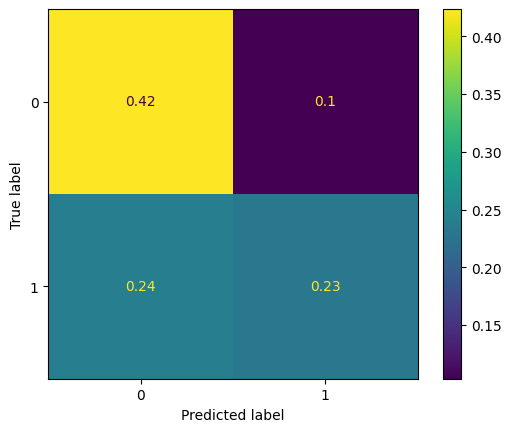

In [50]:
all_y_train['lp_knn'] = lp_knn.transduction_
print(all_y_train[all_y_train['masked_deposit']!=-1]['masked_deposit'].equals(all_y_train[all_y_train['masked_deposit']!=-1]['lp_knn']))  # unmasked values will stay the same in label propagation

cm= confusion_matrix(all_y_train[all_y_train['masked_deposit']==-1][label_col], all_y_train[all_y_train['masked_deposit']==-1]['lp_knn'], normalize='all')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lp_knn.classes_)
disp.plot()
plt.show()

### RBF Kernel

In [51]:
model_lp_rbf = LabelPropagation(kernel='rbf',
                              # High gamma extends the influence of each individual point wide, hence creating a smooth transition in label probabilities. Meanwhile, low gamma leads to only the closest neighbors having influence over the label probabilities.
                              gamma=70,   
                              n_neighbors=20, 
                              max_iter=1000,
                              n_jobs=-1)

lp_rbf = model_lp_rbf.fit(scaled_X_train, y_train)

y_pred = lp_rbf.predict(scaled_X_test)
auc = roc_auc_score(all_y_test[label_col], y_pred)
print(f'Testing AUC is {auc}')

Testing AUC is 0.6519941731812022


True


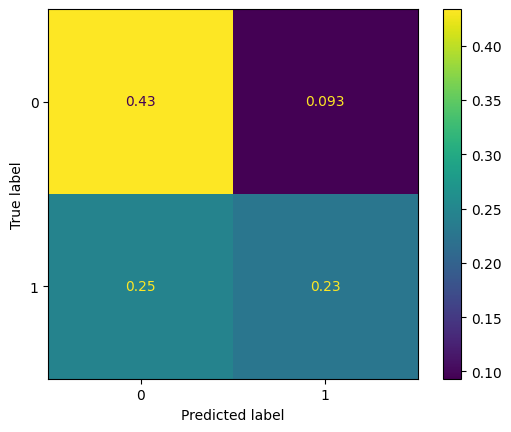

In [52]:
all_y_train['lp_rbf'] = lp_rbf.transduction_
print(all_y_train[all_y_train['masked_deposit']!=-1]['masked_deposit'].equals(all_y_train[all_y_train['masked_deposit']!=-1]['lp_rbf']))  # unmasked values will stay the same in label propagation

cm= confusion_matrix(all_y_train[all_y_train['masked_deposit']==-1][label_col], all_y_train[all_y_train['masked_deposit']==-1]['lp_rbf'], normalize='all')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lp_rbf.classes_)
disp.plot()
plt.show()

## Label Spreading

### KNN Kernel

In [53]:
model_ls_knn = LabelSpreading(kernel='knn',
                          n_neighbors=7,
                          alpha=0.5, # Clamping factor, alpha=0 means keeping the initial label information; alpha=1 means replacing all initial information.
                          max_iter=1000,
                          n_jobs=-1
                         )

ls_knn = model_ls_knn.fit(scaled_X_train, y_train)

y_pred = ls_knn.predict(scaled_X_test)
auc = roc_auc_score(all_y_test[label_col], y_pred)
print(f'Testing AUC is {auc}')

Testing AUC is 0.6713459190150373


True


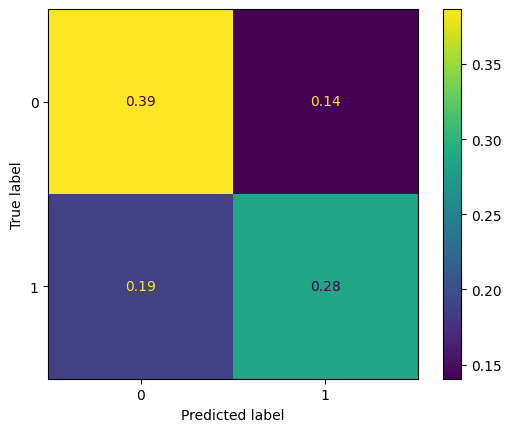

In [55]:
all_y_train['ls_knn'] = ls_knn.transduction_
print(all_y_train[all_y_train['masked_deposit']!=-1]['masked_deposit'].equals(all_y_train[all_y_train['masked_deposit']!=-1]['ls_knn']))  # unmasked values will stay the same in label propagation

cm= confusion_matrix(all_y_train[all_y_train['masked_deposit']==-1][label_col], all_y_train[all_y_train['masked_deposit']==-1]['ls_knn'], normalize='all')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ls_knn.classes_)
disp.plot()
plt.show()

### RBF Kernel

In [56]:
model_ls_rbf = LabelSpreading(kernel='rbf',
                              gamma=70,   
                              n_neighbors=20, 
                              max_iter=1000,
                              n_jobs=-1)

ls_rbf = model_ls_rbf.fit(scaled_X_train, y_train)

y_pred = ls_rbf.predict(scaled_X_test)
auc = roc_auc_score(all_y_test[label_col], y_pred)
print(f'Testing AUC is {auc}')

Testing AUC is 0.6732707032612285


True


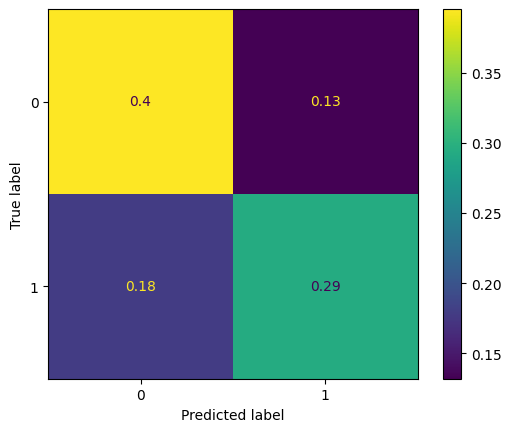

In [57]:
all_y_train['ls_rbf'] = ls_rbf.transduction_
print(all_y_train[all_y_train['masked_deposit']!=-1]['masked_deposit'].equals(all_y_train[all_y_train['masked_deposit']!=-1]['ls_rbf']))  # unmasked values will stay the same in label propagation

cm= confusion_matrix(all_y_train[all_y_train['masked_deposit']==-1][label_col], all_y_train[all_y_train['masked_deposit']==-1]['ls_rbf'], normalize='all')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ls_rbf.classes_)
disp.plot()
plt.show()

## Self Training Classifier

In [69]:
# using the best params from all_real_forecast.ipynb
params = {'num_leaves': 4, 'learning_rate': 0.17937097905882862, 'bagging_fraction': 0.8506740422636537, 
          'feature_fraction': 0.6643670461510903, 'bagging_freq': 18, 'min_data_in_leaf': 1133, 'num_iterations': 2956, 
          'objective': 'binary', 'metric': 'auc', 'random_state': 10, 'verbosity': -1, 'boosting': 'gbdt', 'num_threads': 4}
model_lgbm = LGBMClassifier(**params)

model_st = SelfTrainingClassifier(base_estimator=model_lgbm,
                                             criterion='k_best',
                                             k_best = 10,
                                             max_iter=1000,
                                             verbose=True
                                            )
st = model_st.fit(encoded_X_train, y_train)

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.6643670461510903, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6643670461510903
[LightGBM] [Warning] min_data_in_leaf is set=1133, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1133
[LightGBM] [Warning] bagging_fraction is set=0.8506740422636537, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8506740422636537
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=18, subsample_freq=0 will be ignored. Current value: bagging_freq=18
End of iteration 1, added 10 new labels.
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.6643670461510903, colsample_bytree=1.0 will be ignored. Curr

In [70]:
y_pred = st.predict(encoded_X_test)
auc = roc_auc_score(all_y_test[label_col], y_pred)
print(f'Testing AUC is {auc}')

Testing AUC is 0.5126276031138092


True


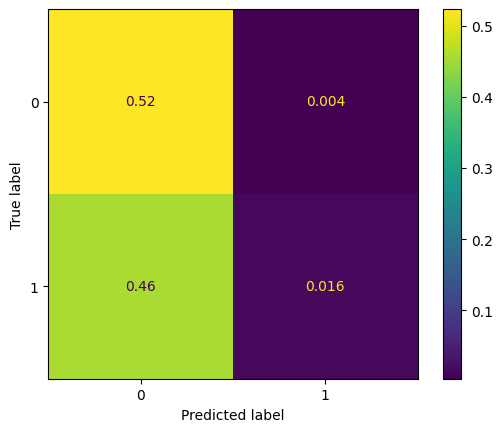

In [71]:
all_y_train['st'] = st.transduction_
print(all_y_train[all_y_train['masked_deposit']!=-1]['masked_deposit'].equals(all_y_train[all_y_train['masked_deposit']!=-1]['st']))  # unmasked values will stay the same in label propagation

cm= confusion_matrix(all_y_train[all_y_train['masked_deposit']==-1][label_col], all_y_train[all_y_train['masked_deposit']==-1]['st'], normalize='all')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=st.classes_)
disp.plot()
plt.show()